In [1]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
from IPython import display

import time
import traceback
import random

from chirpotle.context import tpy_from_context

# triggered-jamming

In this notebook, we will have a first look at jamming. We extend the basic channel test from `tx-test` by a third node which acts as an attacker and tries to jam the communication between the first and second node.

Our goal is to test the effectiveness of the jammer:
- by data rate
- by frame length

In this notebook, we talk about a **triggered jammer**, that means, the jammer doesn't transmit continuously, but it starts transmitting when it senses that a frame is in transmission.

## Node Selection

For the experiments in this notebook, we have node `alice` which transmits frames to node `bob`.

A third node is the `jammer`. The jammer works most successful if it is close to the receiver (`bob` in this case), so that the SNR for a frame sent by the jammer is 6dB higher at `bob`, compared to `alice`'s valid frames.

For more information on node configuration and troubleshooting, see the `01-tx-test` notebook.

In [2]:
tc, devices = tpy_from_context()


You are running TPyControl in version 0.0.0
Connected to 2 remote nodes

node    host               proxy                                 modules (name[:type])
------  -----------------  ------------------------------------  -----------------------
alice   loranode1.example  PYRO:tpynode@loranode1.example:42337  lora:LoRa
bob     loranode2.example  PYRO:tpynode@loranode2.example:42337  lora:LoRa jammer:LoRa


From the list above we see the available modules. On node `alice` there is a single node `lora`, on node `bob` we have the node `lora` (will be the legitimate receiver) and `jammer` which will be our attacker node.

In [3]:
# Transmitting node
alice  = tc.nodes['alice']['lora']

# Receiving node
bob    = tc.nodes['bob']['lora']

# Jammer (close to the receiver)
jammer = tc.nodes['bob']['jammer']

## Channel Configuration

Here we configure the channel that we will use. The settings below match the EU868 region of LoRaWAN. Note that frequency, bandwidth and spreadingfactor will be overidden during the experiment.

The `invertiq` IQ settings are the same for all nodes. With the configuration below, the nodes expect incoming frames with the same polarity as they transmit it. For the jammer, this means it will transmit jamming frames in the same polarity. It is important for the jammer to use the same polarity as the jammed signal, as otherwise performance will degrade notably.

In [4]:
channel = {
    'frequency': 868100000,
    'bandwidth': 125,
    'spreadingfactor': 7,
    'syncword': 18,
    'codingrate': 5,
    'invertiqtx': True,
    'invertiqrx': False,
    'explicitheader': True,
}

alice.set_lora_channel(**channel)
bob.set_lora_channel(**channel)
jammer.set_lora_channel(**channel)

{'frequency': 868099975,
 'bandwidth': 125,
 'spreadingfactor': 7,
 'syncword': 18,
 'codingrate': 5,
 'invertiqtx': True,
 'invertiqrx': False,
 'explicitheader': True}

## Variation of Data Rate and Frame Length

We now define the data rates (according to EU868) and the frame lengths that we want to evaluate. The data rate `dict` will be merged into the 

In [5]:
# LoRaWAN data rates according to EU868 regional specification?
datarates = {
    "DR0": {"spreadingfactor": 12, "bandwidth": 125},
    "DR1": {"spreadingfactor": 11, "bandwidth": 125},
    "DR2": {"spreadingfactor": 10, "bandwidth": 125},
    "DR3": {"spreadingfactor":  9, "bandwidth": 125},
    "DR4": {"spreadingfactor":  8, "bandwidth": 125},
    "DR5": {"spreadingfactor":  7, "bandwidth": 125},
    "DR6": {"spreadingfactor":  7, "bandwidth": 250},
}

# Which frame lengths should be tested per data rate?
frame_lengths = [
    1,
    3,
    6,
    9,
    12, # LoRaWAN data message minimum frame length
]

# Use the data rates to get lables for the plot
dr_labels = sorted(datarates.keys())

Now, we configure fixed the parameters for the experiments.

The **number of rounds** decides how many packets are sent for each data rate and frame lengths.

The **frequency** is the frequency to transmit on (like already specified in the channel definition above). Note that each frequency comes with its specific duty cycle.

The **duty cycle** for the frequency, as percentage. For a 10% duty cycle, use a value of `0.1`.

In [6]:
# Parameter: Number of rounds for the experiment
num_rounds = 10

# Frequency to use
frequency = 869525000

# Duty Cycle on that frequency (0.10 = 10% duty cycle)
duty_cycle = 0.10

Now, we implement the experiment. To make the chart (and the code) not too complex, we go for one chart per frame length.

As the time for the experiment grows, we now also implement an automatic retry if the connection should break in between. Therefore, the code for a single run is wrapped into a `while retries < 3:` / `try:` loop.

You will see that the jammer usually is too slow to jam single-byte frames but quickly gets more effective when the frame length increases. The difference for each data rate is caused by the non-continuous relation between payload length and frame length, see [Figure 5 in our paper](https://arxiv.org/abs/2005.11555) to learn more on this. For a frame length of 6 bytes, the jammer already gets most of the frames.

Keep in mind though that we are talking about LoRa frames here. The shortest LoRa**WAN** frame has a protocol overhead of 12 bytes. At this frame size, we can call the jammer fully reliable.

<IPython.core.display.Javascript object>


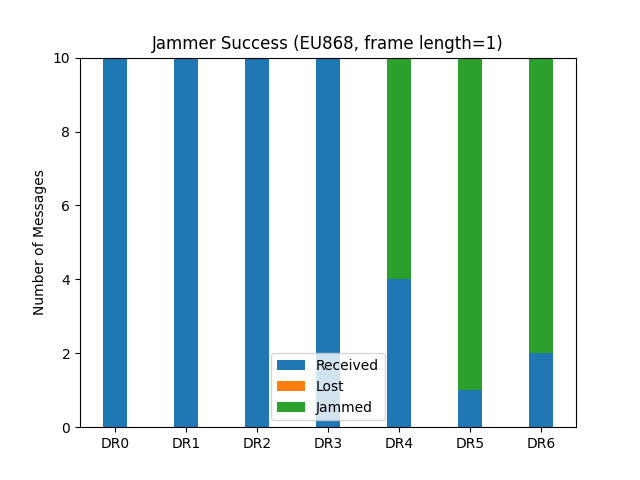

<IPython.core.display.Javascript object>


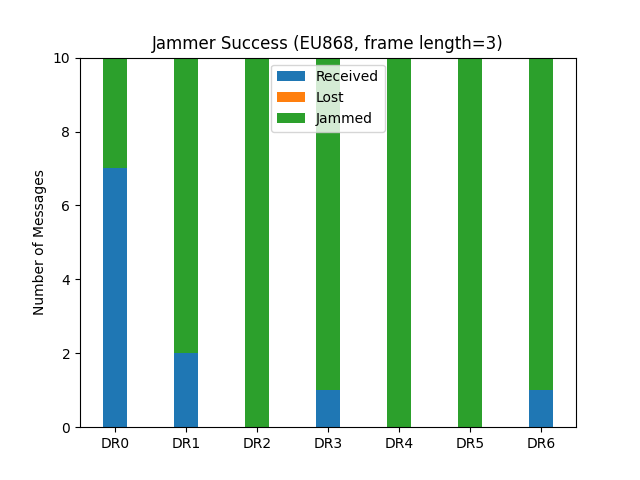

<IPython.core.display.Javascript object>


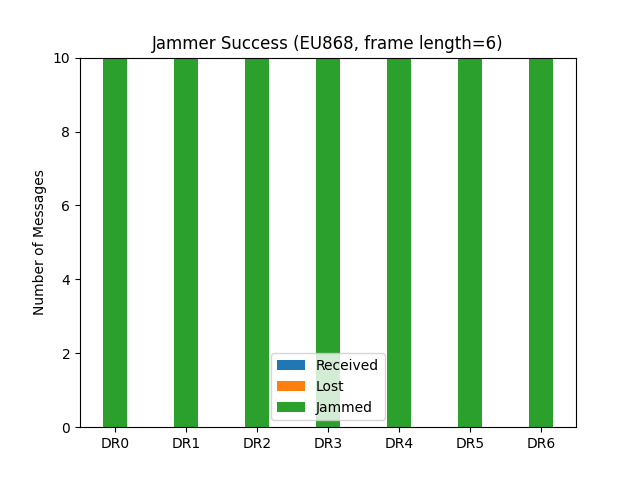

<IPython.core.display.Javascript object>


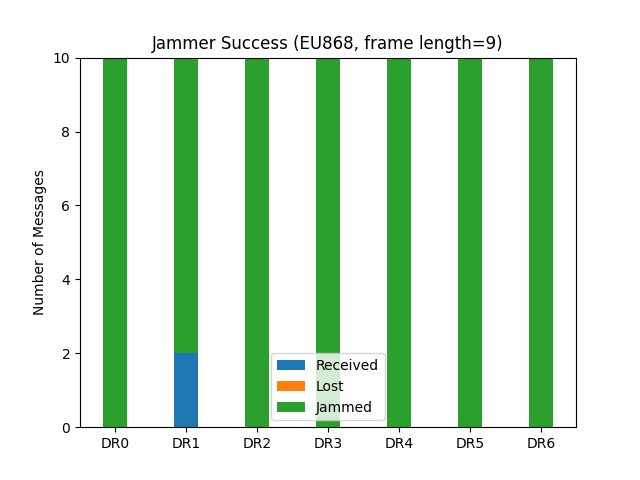

<IPython.core.display.Javascript object>


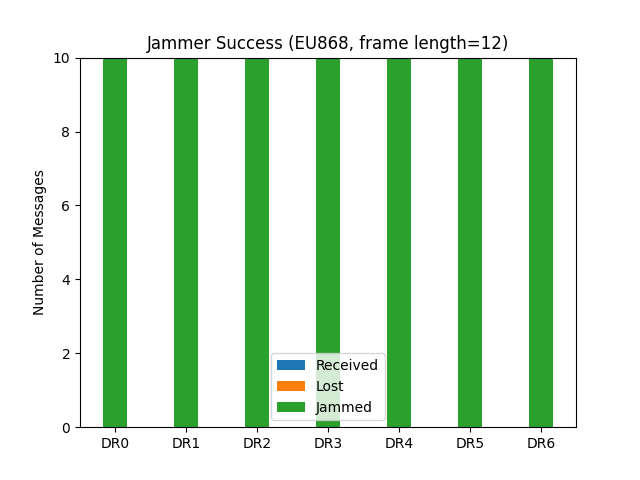

In [7]:
# Create one chart for each frame length
for frame_len in frame_lengths:
    # Received message count (per data rate)
    count_recv = [0 for _ in dr_labels]

    # Lost message count (per data rate)
    count_lost = [0 for _ in dr_labels]

    # Corrupted message count (per data rate)
    count_corrupt = [0 for _ in dr_labels]

    # matplotlib plot
    fig, ax = plt.subplots()

    # Stack the bars for each data rate
    bar_width = 0.35
    bar_recv = ax.bar(dr_labels, count_recv, bar_width, label='Received')
    bar_lost = ax.bar(dr_labels, count_lost, bar_width, bottom=count_recv, label='Lost')
    bar_corrupt = ax.bar(dr_labels, count_corrupt, bar_width, bottom=count_lost, label='Jammed')

    # Legends and labels
    ax.set_ylim([0,num_rounds])
    ax.set_ylabel('Number of Messages')
    ax.set_title('Jammer Success (EU868, frame length=%d)' % frame_len)
    ax.legend()

    # Function to update the data after each frame
    def update_chart():
        for n in range(len(dr_labels)):
            # We need to update the height and y-offset manually.
            # recv is at the bottom
            bar_recv[n].set_height(count_recv[n])
            # then comes the lost bar (on top of recv)
            bar_lost[n].set_height(count_lost[n])
            bar_lost[n].set_y(count_recv[n])
            # and finally the corrupted bar (on top of recv and lost)
            bar_corrupt[n].set_height(count_corrupt[n])
            bar_corrupt[n].set_y(count_recv[n]+count_lost[n])
        fig.canvas.flush_events()
        fig.canvas.draw()

    plt.show()
    for n in range(num_rounds):
        for drname,dridx in zip(dr_labels,range(len(dr_labels))):
            # Retry each experiment 3 times before failing. This helps with long-running experiments:
            retries = 0
            success = False
            while retries < 3 and not success:
                try:
                    # Create channel for this run and set it (this will also sent devices to standby)
                    channel_run = {**channel,**datarates[drname],"frequency":frequency}
                    alice.set_lora_channel(**channel_run)
                    bob.set_lora_channel(**channel_run)
                    jammer.set_lora_channel(**channel_run)

                    # Enable the jammer
                    # Using the sniffer with the "internal" action means that the jammer on the same
                    # node will be triggered immediately when a frame is sniffed.
                    jammer.enable_sniffer(action="internal")
                    
                    # Make bob the receiver
                    bob.receive()

                    # Create random frame data
                    frm = [random.randrange(0, 256) for _ in range(frame_len)]

                    # Send and capture time
                    txstart = time.time()
                    alice.transmit_frame(frm, blocking=True)
                    txend = time.time()
                    
                    # Disable the jammer
                    jammer.standby()

                    # Wait a short moment so that the receiver is done
                    time.sleep(0.2)

                    # Check if the receiver got the same frame
                    frm_state="lost"
                    frm_rx = bob.fetch_frame()
                    while frm_rx is not None and frm_state!="received":
                        if frm_rx['payload']==frm:
                            frm_state="received"
                        elif len(frm_rx['payload'])==frame_len:
                            frm_state="corrupted"
                        frm_rx = bob.fetch_frame()
                    bob.standby()

                    # Update the data
                    if frm_state=="received":
                        count_recv[dridx]+=1
                    elif frm_state=="corrupted":
                        count_corrupt[dridx]+=1
                    else:
                        count_lost[dridx]+=1

                    # Update the chart to show real-time results
                    update_chart()

                    # Wait the remaining time of the duty cycle
                    frm_duration=txend-txstart
                    time.sleep(frm_duration/duty_cycle-frm_duration)
                    
                    # Set the success flag to continue to the next run
                    success = True
                except KeyboardInterrupt:
                    raise # Pass-through for the keyboard interrupt (so you can interrupt the Kernel)
                except:
                    traceback.print_exc()
                    retries+=1